### Introduction
Personalized medicine is redefining how cancer is treated. However to deliver this state-of-the-art medicine genetic mutations need to be classified from literature sources.

The main challenge of this is to distinguish which mutations contribute to tumor growth (drivers) and which mutations are neutral.

Currently this interpretation of genetic mutations is being done by manually. This is a very time-consuming task for a clinical pathologist as they must manually review and classify every single genetic mutation based on evidence from text-based clinical literature. 

Here we aim to solve this with a machine learning solution to this problem to help speed upo this time-consuming procedure and produce results with significant accuracy.  

![gene](https://images.unsplash.com/photo-1643780668909-580822430155?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1332&q=80)


This project entails making features out of medical literature data and developing a machine learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations. 

WE will experiment with different models such as logistic regression, random forest, knn and naive bayes to find the best-fitting model for the problem. 

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
nltk.download('omw-1.4')
from pymongo import MongoClient
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn. metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from pretty_confusion_matrix import pp_matrix_from_data
from sklearn.preprocessing import normalize
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/robertmoss/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/robertmoss/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/robertmoss/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
#reading in the data
training_text = pd.read_csv("data/training_text.csv", sep="\|\|",engine="python", names=["ID", "TEXT"], skiprows=1)
testing_text = pd.read_csv("data/test_text.csv", sep="\|\|", engine="python", names=["ID", "TEXT"], skiprows=1)

training_variants = pd.read_csv("data/training_variants.csv")
testing_variants = pd.read_csv("data/test_variants.csv")

In [3]:
#looking at the training text dataset
training_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [4]:
#looking at the training variants data
training_variants.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [5]:
#lets look at the shape of each dataframe
print('training variants shape is', training_variants.shape)
print('testing variants shape is', testing_variants.shape)
print('training text shape is', training_text.shape)
print('test text shape is', testing_text.shape)

training variants shape is (3321, 4)
testing variants shape is (5668, 3)
training text shape is (3321, 2)
test text shape is (5668, 2)


In [6]:
#we need to merge the two dataframes on ID
training_data = pd.merge(training_text, training_variants, on="ID", how="left")
training_data.head()

,ID,TEXT,Gene,Variation,Class
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A,Truncating Mutations,1
1,1,Abstract Background Non-small cell lung canc...,CBL,W802*,2
2,2,Abstract Background Non-small cell lung canc...,CBL,Q249E,2
3,3,Recent evidence has demonstrated that acquired...,CBL,N454D,3
4,4,Oncogenic mutations in the monomeric Casitas B...,CBL,L399V,4


In [7]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   TEXT       3316 non-null   object
 2   Gene       3321 non-null   object
 3   Variation  3321 non-null   object
 4   Class      3321 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


In [8]:
#now need to see with missing values
training_data.isnull().sum()

ID           0
TEXT         5
Gene         0
Variation    0
Class        0
dtype: int64

In [9]:
#lets look at the rows with null text values 
training_data[training_data["TEXT"].isnull()]

,ID,TEXT,Gene,Variation,Class
1109,1109,NaN,FANCA,S1088F,1
1277,1277,NaN,ARID5B,Truncating Mutations,1
1407,1407,NaN,FGFR3,K508M,6
1639,1639,NaN,FLT1,Amplification,6
2755,2755,NaN,BRAF,G596C,7


In [10]:
#get a list of the indices
indices = training_data[training_data["TEXT"].isnull()].index.tolist()
indices

[1109, 1277, 1407, 1639, 2755]

In [11]:
#fill in the missing text values with the gene and the variation. This information is found in other text examples
training_data.loc[training_data['TEXT'].isnull(), 'TEXT'] = training_data['Gene'] + " " + training_data['Variation'] 
training_data.loc[indices,]


,ID,TEXT,Gene,Variation,Class
1109,1109,FANCA S1088F,FANCA,S1088F,1
1277,1277,ARID5B Truncating Mutations,ARID5B,Truncating Mutations,1
1407,1407,FGFR3 K508M,FGFR3,K508M,6
1639,1639,FLT1 Amplification,FLT1,Amplification,6
2755,2755,BRAF G596C,BRAF,G596C,7


### The Data Dictionary
1. ID = the id of the row used to link the mutation to the clinical evidence
2. Text = Associated Medical Literature
3. Gene = The Gene where the genetic material is located
4. Variation = The ammino acid change for this mutation
5. Class = the class this genetic mutation has been classified as 1-9.

In [12]:
#create the testing data same as the training data
testing_data = pd.merge(testing_text, testing_variants, on="ID", how="left")
testing_data.head()


,ID,TEXT,Gene,Variation
0,0,2. This mutation resulted in a myeloproliferat...,ACSL4,R570S
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...,NAGLU,P521L
2,2,Vascular endothelial growth factor receptor (V...,PAH,L333F
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...,ING1,A148D
4,4,Abstract Retinoblastoma is a pediatric retina...,TMEM216,G77A


In [13]:
#check if any null values
testing_data.isnull().sum()

ID           0
TEXT         1
Gene         0
Variation    0
dtype: int64

In [14]:
#looking at the missing value row
testing_data[testing_data['TEXT'].isnull()]

,ID,TEXT,Gene,Variation
1623,1623,NaN,AURKB,Amplification


In [15]:
#get the index
index = testing_data[testing_data['TEXT'].isnull()].index.tolist()
index

[1623]

In [16]:
#fill in the Null text data same as before
testing_data.loc[testing_data['TEXT'].isnull(),'TEXT'] = testing_data['Gene'] + " " + testing_data['Variation']
testing_data.loc[index,]

,ID,TEXT,Gene,Variation
1623,1623,AURKB Amplification,AURKB,Amplification


In [17]:
training_data['Class'].unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

### Data Analysis


In [18]:
#lets look at the frequency of the classes
print("The number and value of classes are:")
classes = sorted(training_data['Class'].unique())
print("The number of classes is", len(classes))
print("The value of the classes is ", classes)


The number and value of classes are:
The number of classes is 9
The value of the classes is  [1, 2, 3, 4, 5, 6, 7, 8, 9]


(array([568., 452.,  89., 686., 242., 275., 953.,  19.,  37.]),
 array([1.        , 1.88888889, 2.77777778, 3.66666667, 4.55555556,
        5.44444444, 6.33333333, 7.22222222, 8.11111111, 9.        ]),
 <BarContainer object of 9 artists>)

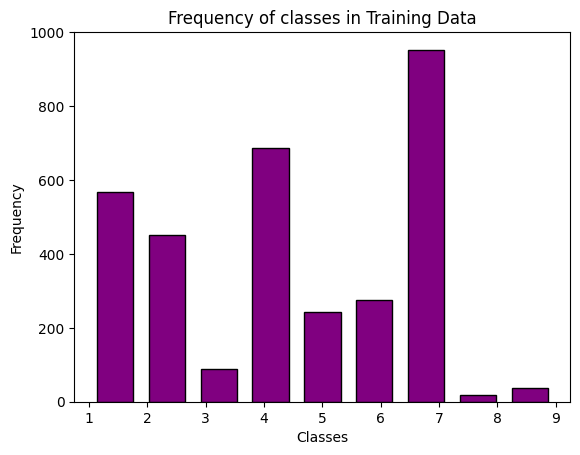

In [19]:
#now lets look at the frequency of the classes
fig,ax = plt.subplots()
#set the title
ax.set_title("Frequency of classes in Training Data")
#adding labels
ax.set_xlabel('Classes')
ax.set_ylabel('Frequency')
plt.hist(training_data['Class'], bins=9, align='mid', color='purple', edgecolor='black', rwidth=0.7)


Here we see that the number of observations in 7th class is too much compared to the others and the observations in 8th and 9th class are way too low. This is a problem of imbalanced data.  

Imbalanced of classes can lead to biases in the predications from our classifying algorithms. We can deal with this is several ways such as sampling, modifying the cost function, moving the threshold and others.   

In [20]:
#looking at the number of genes
print('The output of the number and value of Genes is')
genes = sorted(training_data['Gene'].unique())
print('The number of genes is ', len(genes))
print('The value of genes are ', genes)

The output of the number and value of Genes is
The number of genes is  264
The value of genes are  ['ABL1', 'ACVR1', 'AGO2', 'AKT1', 'AKT2', 'AKT3', 'ALK', 'APC', 'AR', 'ARAF', 'ARID1A', 'ARID1B', 'ARID2', 'ARID5B', 'ASXL1', 'ASXL2', 'ATM', 'ATR', 'ATRX', 'AURKA', 'AURKB', 'AXIN1', 'AXL', 'B2M', 'BAP1', 'BARD1', 'BCL10', 'BCL2', 'BCL2L11', 'BCOR', 'BRAF', 'BRCA1', 'BRCA2', 'BRD4', 'BRIP1', 'BTK', 'CARD11', 'CARM1', 'CASP8', 'CBL', 'CCND1', 'CCND2', 'CCND3', 'CCNE1', 'CDH1', 'CDK12', 'CDK4', 'CDK6', 'CDK8', 'CDKN1A', 'CDKN1B', 'CDKN2A', 'CDKN2B', 'CDKN2C', 'CEBPA', 'CHEK2', 'CIC', 'CREBBP', 'CTCF', 'CTLA4', 'CTNNB1', 'DDR2', 'DICER1', 'DNMT3A', 'DNMT3B', 'DUSP4', 'EGFR', 'EIF1AX', 'ELF3', 'EP300', 'EPAS1', 'EPCAM', 'ERBB2', 'ERBB3', 'ERBB4', 'ERCC2', 'ERCC3', 'ERCC4', 'ERG', 'ERRFI1', 'ESR1', 'ETV1', 'ETV6', 'EWSR1', 'EZH2', 'FAM58A', 'FANCA', 'FANCC', 'FAT1', 'FBXW7', 'FGF19', 'FGF3', 'FGF4', 'FGFR1', 'FGFR2', 'FGFR3', 'FGFR4', 'FLT1', 'FLT3', 'FOXA1', 'FOXL2', 'FOXO1', 'FOXP1', 'FUBP1

<Axes: xlabel='Variation', ylabel='Frequency'>

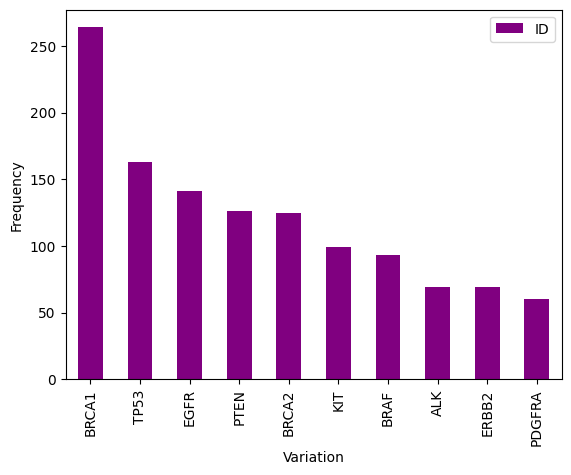

In [21]:
#since there are 264 genes lets look at the top ten
df_t10_genes = training_data.groupby(by='Gene')
df_t10_genes_plot = df_t10_genes.count().sort_values(by='ID', ascending=False).head(10).plot(kind='bar', y='ID', ylabel='Frequency', xlabel='Variation', color='purple')
df_t10_genes_plot

In [22]:
training_data['Gene'].value_counts()

BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
         ... 
RYBP        1
MDM2        1
CTLA4       1
ARID1A      1
FAM58A      1
Name: Gene, Length: 264, dtype: int64

Here we found some of the most frequent genes in the dataset.

In [23]:
#now lets look at the variations
print('Output the number and value of the variations')
variations = sorted(training_data['Variation'].unique())
print('The number of variations is ', len(variations))
print('The value of the variations are ', variations)

Output the number and value of the variations
The number of variations is  2996
The value of the variations are  ['1_2009trunc', '2010_2471trunc', '256_286trunc', "3' Deletion", '385_418del', '422_605trunc', '533_534del', '534_536del', '550_592del', '560_561insER', '596_619splice', '963_D1010splice', '981_1028splice', 'A1020V', 'A1022E', 'A1065T', 'A1066V', 'A1099T', 'A111P', 'A1131T', 'A113_splice', 'A1170V', 'A11_G12insGA', 'A1200V', 'A120S', 'A121E', 'A121P', 'A121V', 'A122*', 'A1234T', 'A126D', 'A126G', 'A126S', 'A126V', 'A134D', 'A1374V', 'A1459P', 'A146T', 'A146V', 'A148T', 'A149P', 'A1519T', 'A151T', 'A159T', 'A161S', 'A161T', 'A1669S', 'A1685S', 'A1701P', 'A1708E', 'A1708V', 'A171V', 'A1752P', 'A1752V', 'A1789S', 'A1789T', 'A1823T', 'A1830T', 'A1843P', 'A1843T', 'A18D', 'A197T', 'A19V', 'A2034V', 'A205T', 'A209T', 'A211D', 'A232V', 'A2351G', 'A23E', 'A2425T', 'A246P', 'A263V', 'A2643G', 'A2717S', 'A272V', 'A2770T', 'A290T', 'A298T', 'A339V', 'A347T', 'A349P', 'A34D', 'A36P', 'A

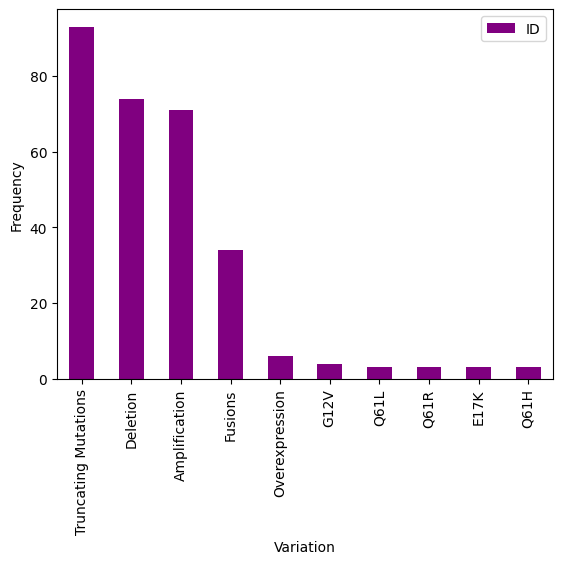

In [24]:
#there are 2996 variations again lets look at the top ten
df_t10_variation = training_data.groupby(by='Variation')
df_t10_variation_plot = df_t10_variation.count().sort_values(by='ID', ascending=False).head(10).plot(kind='bar', y='ID', ylabel='Frequency', xlabel='Variation', color='purple')

We see here that out of the total 3321 observations there are 2996 variations. This means that there is too much randomization in this feature, and constructing a model based solely on this feature is unlikely to address our problem.  

### Text Preprocessing
Here we convert text into a clean, consistent format that can subsequently be red into a model to generate inferences from it. 

The steps involved are:
1. Lower case conversion: All the text is converted to lowercase. This enables uniformity among the texts and stops the machine learning models from considering words in different cases as different words.
2. Stop Words Removal: Stop words are terms that are frequently used in text. They don not help distinguish texts from one another and are therefore not significant. 
3. Stemming: Stemming is an NPL approach that reduces inflection in words to their root forms. It assists in text, word and document processing for text normalization. 
4. Lemmatization: Lemmatization is a more advanced type of stemming, in which words are converted into their matching root from know as a "lemma". While stemming uses a lookup table to reduce all words to their stem, it does not use any knowledge of the parts of speech or the context of a word. 
5. Tokenization: Tokenization means splitting the sentences into streams of words which eventually helps models identify the occurrence of a word in a particular document. 

In [25]:
#create a clean text function
def clean_text(text):
    ''' Preprocess the text by following some cleaning steps'''

    #remove the following special characters
    REPLACE_BY_SPACERE = re.compile('[/(){}[]|@,;]')
    BAD_SYMBOLSRE = re.compile('[^a-z]')
    #initialize lemmenization
    lemmatizer = WordNetLemmatizer()
    #remove stopwords
    STOPWORDS = set(stopwords.words('english'))

    #put text into string and lowercase format
    text = str(text)
    text = text.lower()

    #remove single characters
    text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)

    text = BAD_SYMBOLSRE.sub(' ', text)
    text = REPLACE_BY_SPACERE.sub(' ', text)
    #remove stop words and to lemmetization
    cleaned_text = ' '.join(lemmatizer.lemmatize(word) for word in text.split() if word not in STOPWORDS)

    return cleaned_text

In [26]:
#clean the text
training_data['TEXT'] = training_data['TEXT'].apply(clean_text)
training_data['TEXT']

0       cyclin dependent kinase cdks regulate variety ...
1       abstract background non small cell lung cancer...
2       abstract background non small cell lung cancer...
3       recent evidence demonstrated acquired uniparen...
4       oncogenic mutation monomeric casitas b lineage...
                              ...                        
3316    introduction myelodysplastic syndrome md heter...
3317    introduction myelodysplastic syndrome md heter...
3318    runt related transcription factor gene runx al...
3319    runx aml gene frequent target chromosomal tran...
3320    frequent mutation associated leukemia recurren...
Name: TEXT, Length: 3321, dtype: object

In [27]:
#looking at the number of sentences in each text instance
lens = [len(sent.split()) for sent in training_data['TEXT']]
print(lens)

[3912, 3704, 3704, 3502, 3961, 3961, 3961, 9973, 8043, 4082, 3961, 8353, 17556, 8353, 3961, 4392, 5506, 2285, 3961, 2285, 7665, 3961, 3961, 3502, 3502, 3502, 4420, 863, 8359, 863, 863, 12607, 863, 6188, 11414, 3702, 3702, 1777, 1777, 3949, 3949, 11791, 1777, 12802, 1210, 2543, 853, 2543, 5506, 1210, 1632, 1632, 2693, 2543, 1632, 2543, 4012, 2543, 2842, 2160, 2543, 1210, 2160, 3903, 2543, 1632, 3903, 6420, 12574, 6420, 10407, 4254, 7245, 2641, 12775, 4254, 7942, 7942, 4087, 7942, 4087, 7942, 1659, 1659, 3295, 1659, 11339, 11339, 1609, 3368, 10259, 2491, 3368, 2491, 4126, 2942, 12500, 4212, 4389, 4481, 19430, 11418, 7781, 12038, 10164, 12646, 3476, 7588, 4862, 11286, 17405, 3476, 9172, 11832, 11046, 12066, 12066, 9973, 12283, 10063, 1368, 13977, 7869, 7583, 7583, 797, 797, 7583, 7869, 5509, 7869, 12307, 8916, 4989, 7583, 30903, 3172, 3425, 8801, 20333, 289, 18648, 5268, 6451, 18491, 289, 4393, 16703, 7823, 8095, 16370, 2412, 7932, 2291, 5938, 2231, 3713, 1788, 10184, 8348, 13631, 2231, 7

### SPLITTING DATA, Evaluation and Features Extraction

In [28]:
#now lets look at the features we have and how we will evaluate the model. 
#want to predict class and we have three features
#since one gene could fall into many different classes,
#we will look at gene+variation and gene+text+variation


In [29]:
y_true = training_data['Class'].astype(int)
del training_data['Class']

In [30]:
#slit the data
#we have a training and test set already but we need a validation 
#the validation set is used to help fine tune the models hyperparameters and configurations.
X_train, X_rem, y_train, y_rem = train_test_split(training_data, y_true, stratify=y_true, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, stratify=y_rem, test_size=0.5)





In [31]:
print("The len of X_train is {} and y_train is {}".format(len(X_train), len(y_train)))
print("The len of X_val is {} and y_val is {}".format(len(X_val), len(y_val)))
print("The len of X_test is {} and y_test is {}".format(len(X_test), len(y_test)))

The len of X_train is 2656 and y_train is 2656
The len of X_val is 332 and y_val is 332
The len of X_test is 333 and y_test is 333


(array([57., 46.,  9., 69., 24., 27., 96.,  2.,  3.]),
 array([1.        , 1.88888889, 2.77777778, 3.66666667, 4.55555556,
        5.44444444, 6.33333333, 7.22222222, 8.11111111, 9.        ]),
 <BarContainer object of 9 artists>)

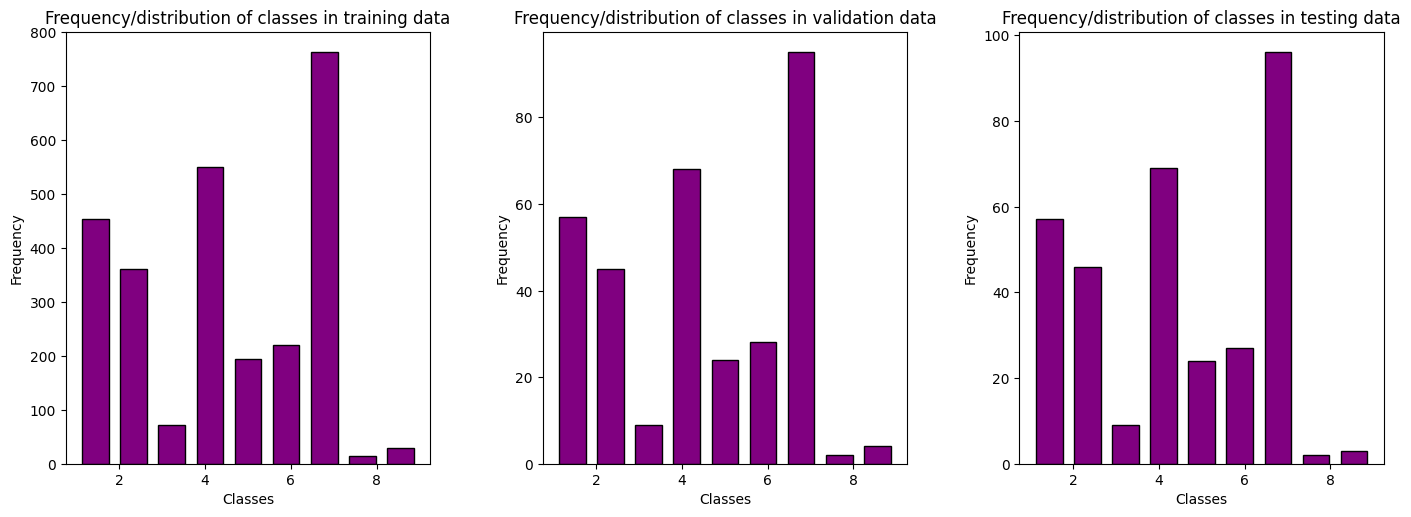

In [32]:
#let's make sure that our data was stratifies properly

fig, ax = plt.subplots(1,3,figsize=(15,6))

fig.tight_layout(pad=5.0)
#set title
ax[0].set_title("Frequency/distribution of classes in training data")
#add labels
ax[0].set_xlabel("Classes")
ax[0].set_ylabel("Frequency")
ax[0].hist(sorted(y_train), bins=9, align='mid', color='purple', edgecolor='black',rwidth=0.7)

#set title
ax[1].set_title("Frequency/distribution of classes in validation data")
#add labels
ax[1].set_xlabel("Classes")
ax[1].set_ylabel("Frequency")
ax[1].hist(sorted(y_val), bins=9, align='mid', color='purple', edgecolor='black',rwidth=0.7)

#set title
ax[2].set_title("Frequency/distribution of classes in testing data")
#add labels
ax[2].set_xlabel("Classes")
ax[2].set_ylabel("Frequency")
ax[2].hist(sorted(y_test), bins=9, align='mid', color='purple', edgecolor='black',rwidth=0.7)



### Feature Extraction, Model Building and Evaluation    

In [38]:
#making a function to predict, and evaluate the model by plotting 
#a confusion matrix and calculating the log loss

def evaluate_model(model, test_features, y_truth, data_type=''):
    #evaluates different models using confusion matrix and log loss
    #predict on the test dataset
    pred = model.predict(test_features)
    #create a pretty matrix with predicted and actual data
    pp_matrix_from_data(y_truth, pred)
    pred_prob = model.predict_proba(test_features)
    #calc log loss
    eval = log_loss(y_truth, pred_prob)
    print("Log loss for " +data_type+ " data")
    print(eval)
    print('*********************************************')

    
          


In [34]:
#extract and test features
#since genes and variations are specific we will represent with one hot encoder
#using get dummies to covert categorical data into dummy or indicator variables
train_gene_feature_onehotCoding = pd.get_dummies(X_train['Gene'], drop_first=True)
val_gene_feature_onehotCoding = pd.get_dummies(X_val['Gene'], drop_first=True)

val_gene_feature_onehotCoding


,AKT1,AKT2,AKT3,ALK,AR,BAP1,BCOR,BRAF,BRCA1,BRCA2,...,SMARCA4,SMO,SPOP,STK11,TET2,TGFBR1,TP53,TSC1,TSC2,VHL
2694,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2942,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
651,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2767,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
944,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2162,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3123,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
#use reindex to handle the unknown categories which didn't appear in the training data
val_gene_feature_onehotCoding = val_gene_feature_onehotCoding.reindex(columns= train_gene_feature_onehotCoding.columns, fill_value=0)

#now for the test gene feature
test_gene_feature_onehotCoding = pd.get_dummies(X_test['Gene'], drop_first=True)
test_gene_feature_onehotCoding = test_gene_feature_onehotCoding.reindex(columns=train_gene_feature_onehotCoding.columns, fill_value=0)


In [36]:
test_gene_feature_onehotCoding

,ACVR1,AGO2,AKT1,AKT2,AKT3,ALK,APC,AR,ARAF,ARID1A,...,TSC1,TSC2,U2AF1,VEGFA,VHL,WHSC1,WHSC1L1,XPO1,XRCC2,YAP1
2736,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1665,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2253,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
972,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2068,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3240,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Logistic Regression 

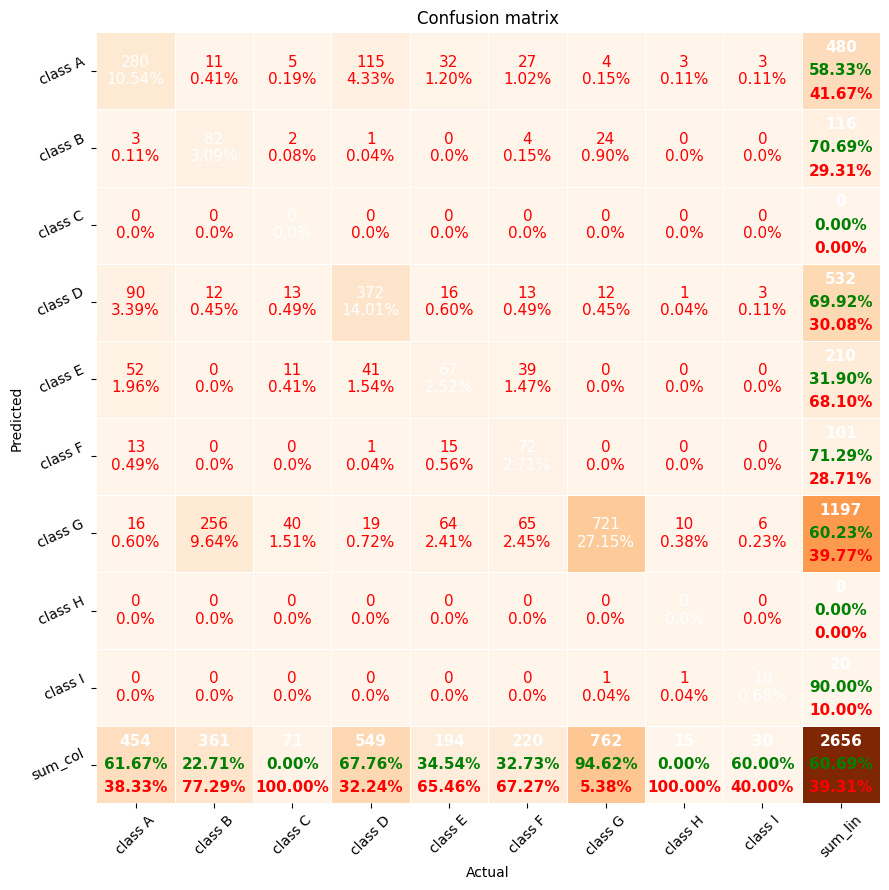

Log loss for training data
1.0816220862335557
*********************************************


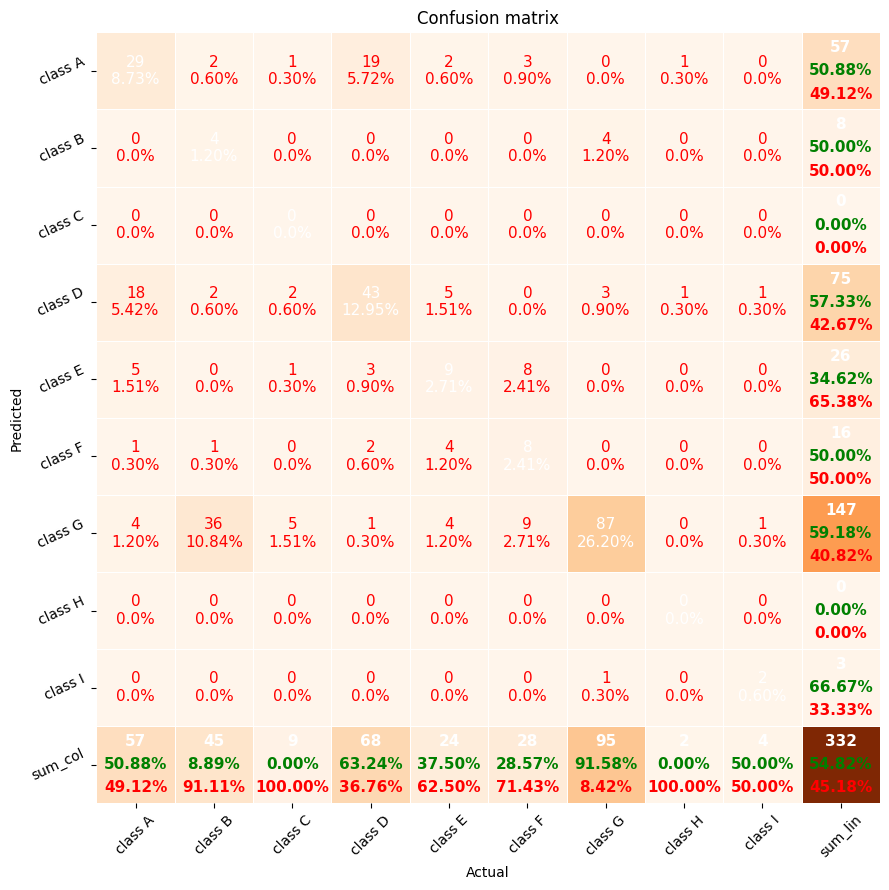

Log loss for evaluation data
1.2156336935548981
*********************************************


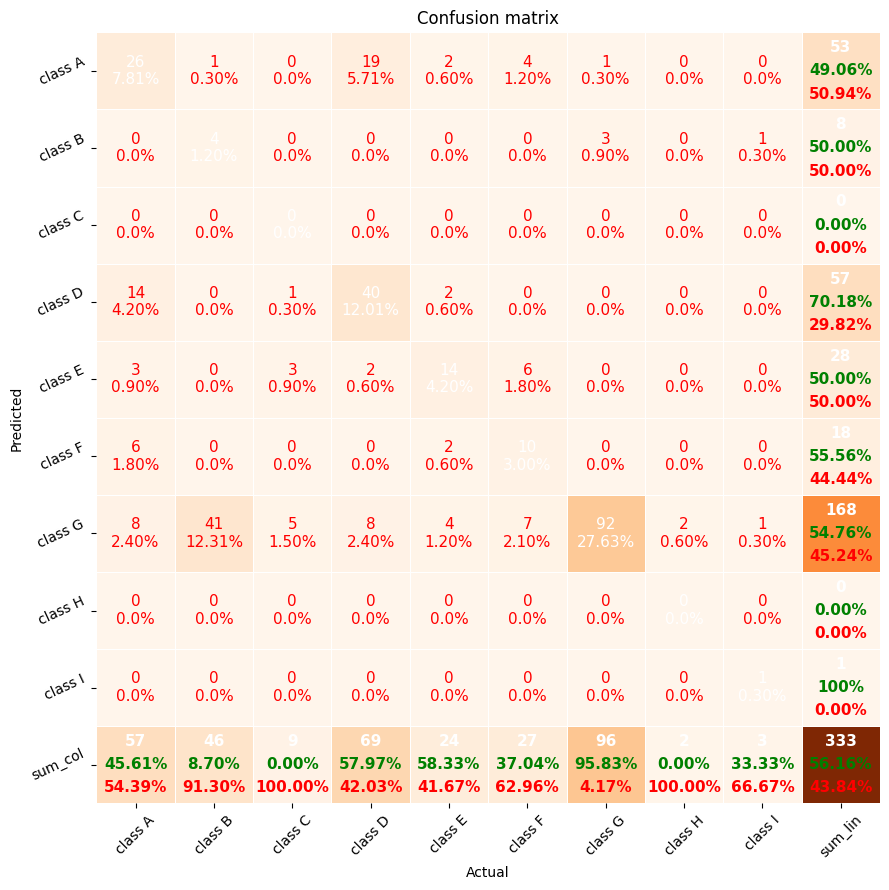

Log loss for testing data
1.2171764266029916
*********************************************


In [40]:
loj = LogisticRegression(random_state=0)
loj_model = loj.fit(train_gene_feature_onehotCoding, y_train)
evaluate_model(loj_model, train_gene_feature_onehotCoding, y_train, 'training')
evaluate_model(loj_model, val_gene_feature_onehotCoding, y_val, 'evaluation')
evaluate_model(loj_model, test_gene_feature_onehotCoding, y_test, 'testing')
